# Color Science

In this tutorial, we will use the package `colour-science`. The following cell will install this package:

In [1]:
!pip install colour-science --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Restart the kernel of this Notebook after installing the package. (Go to "Runtime" and click on "Restart Kernel")

In [2]:
from colour.difference import delta_E_CIE1976, delta_E_CIE1994, delta_E_CIE2000

In [3]:
import os
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import math  
import imageio

In [4]:
! git clone https://github.com/IVRL/CS413-ComputationalPhotography.git
%cd "CS413-ComputationalPhotography/Homework 1 Basics Image Formation"


Cloning into 'CS413-ComputationalPhotography'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 147 (delta 5), reused 1 (delta 0), pack-reused 132
Receiving objects: 100% (147/147), 37.99 MiB | 12.91 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (40/40), done.
/content/CS413-ComputationalPhotography/Homework 1 Basics Image Formation


# Part 1
---------------------------
## Color spaces CIE 1931 XYZ, sRGB and CIE L\*a\*b\* (continued from HW1)

This section is built on top of the exercises on Basics of Image Formation. 

Color can be defined as the combination of different wavelengths of light. In order to represent colors in a standard way, we use color spaces. A color space is a mathematical model that describes how colors can be represented as tuples of numbers.

### Image in CIE 1931 XYZ color space

Using the color matching functions $\bar{x}$, $\bar{y}$ and $\bar{z}$, we obtain the image in the CIE 1931 XYZ color space.

In [5]:
wavelengths = np.arange(400,710,10)
cie_xyz = np.genfromtxt(os.path.join("sensitivities", 'ciexyz31_1.csv'), delimiter=',')
xyz_sensitivity = cie_xyz[np.isin(cie_xyz[:,0], wavelengths), 1:4]
spectral_image = np.load(os.path.join("reflectance_images", 'CDREF31_persilcolour.npy'))
illuminant = np.load(os.path.join('illuminants', 'D65.npy'))
illuminant = illuminant[np.isin(illuminant[:,0], wavelengths), 1]
print(wavelengths.shape, xyz_sensitivity.shape, spectral_image.shape, illuminant.shape)

(31,) (31, 3) (31, 256, 336) (31,)


In [6]:
rho_X = np.sum(xyz_sensitivity[:,0].reshape(-1,1,1) * 
           illuminant.reshape(-1,1,1) * 
           spectral_image, 0)
rho_Y = np.sum(xyz_sensitivity[:,1].reshape(-1,1,1) * 
           illuminant.reshape(-1,1,1) * 
           spectral_image, 0)
rho_Z = np.sum(xyz_sensitivity[:,2].reshape(-1,1,1) * 
           illuminant.reshape(-1,1,1) * 
           spectral_image, 0)

result_XYZ = np.stack((rho_X, rho_Y, rho_Z)).transpose(1, 2, 0)
n = 1/result_XYZ.max() # normalization factor n
result_XYZ *= n
assert result_XYZ.shape == (256, 336, 3)

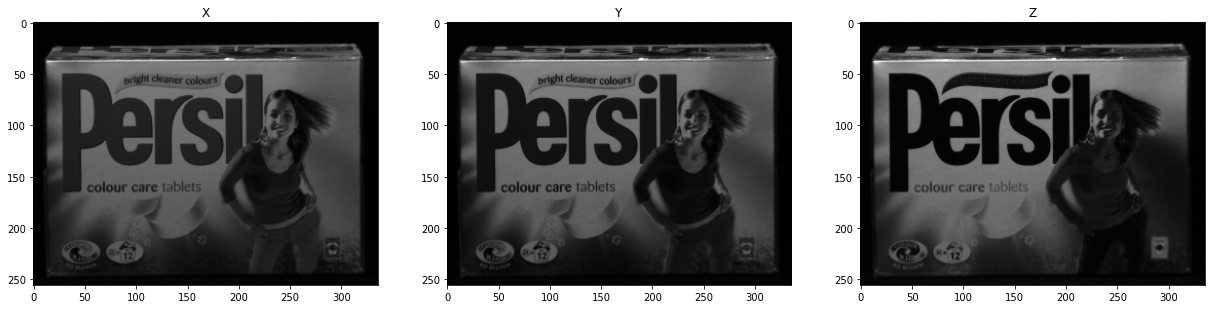

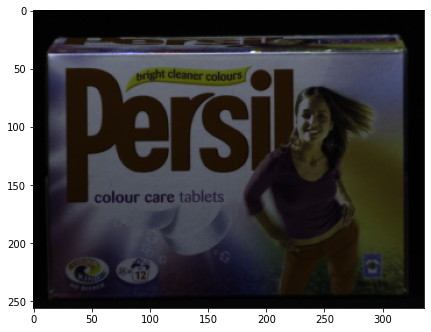

In [7]:
plt.figure(figsize=(21,6))
for i, channel in enumerate(('X', 'Y', 'Z')):
    plt.subplot(1,3,i+1)
    plt.imshow(result_XYZ[:,:,i],  vmin=0., vmax=1., cmap='Greys_r')
    plt.title(channel)

plt.figure(figsize=(7,6))
plt.imshow(result_XYZ, vmin=0., vmax=1.)

### Image in sRGB and CIE L\*a\*b\* color spaces

If you computed the image correctly in the CIE 1931 XYZ color space, the code below should display the image in sRGB and CIE L\*a\*b\* color spaces.

In [8]:
from skimage.color import xyz2rgb, rgb2lab
RGBresult  = xyz2rgb(result_XYZ)
LABresult = rgb2lab(RGBresult)

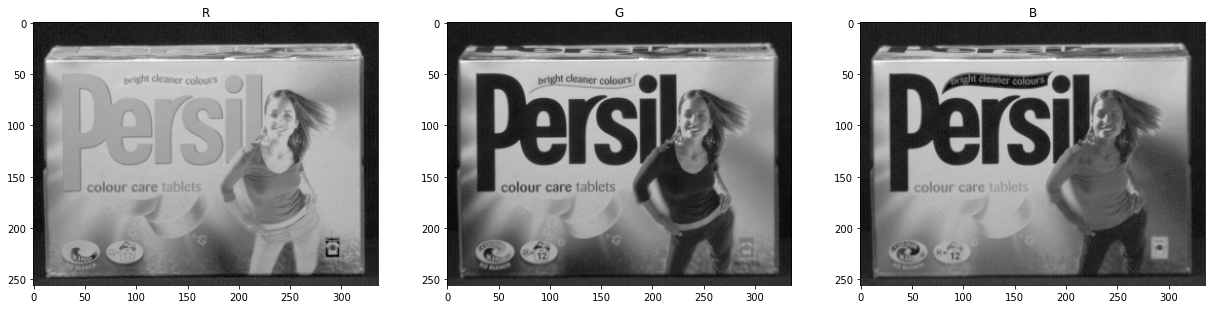

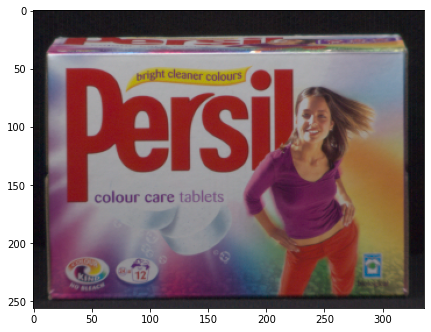

In [9]:
plt.figure(figsize=(21,6))
for i, channel in enumerate(('R', 'G', 'B')):
    plt.subplot(1,3,i+1)
    plt.imshow(RGBresult[:,:,i], vmin=0., vmax=1., cmap='Greys_r')
    plt.title(channel)   

plt.figure(figsize=(7,6))
plt.imshow(RGBresult) 

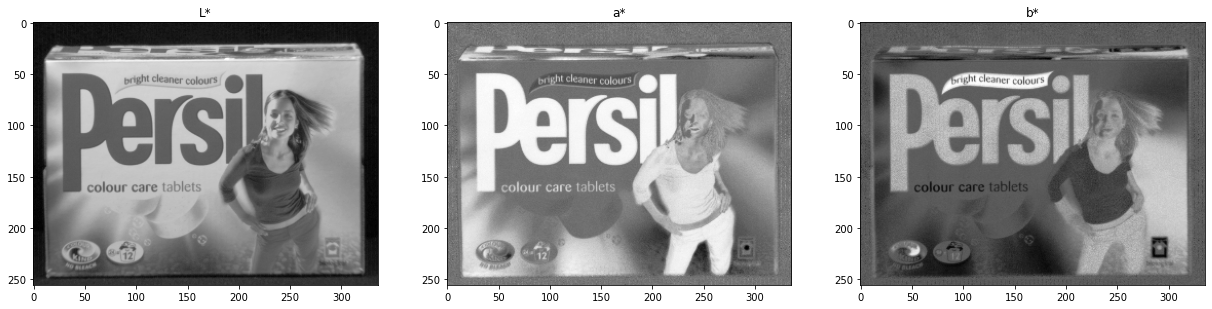

In [10]:
plt.figure(figsize=(21,6))
for i, channel in enumerate(('L*', 'a*', 'b*')):
    plt.subplot(1,3,i+1)
    plt.imshow(LABresult[:,:,i], cmap='Greys_r')
    plt.title(channel)   

## Color Difference $\Delta E^*$

Color difference $\Delta E^*$ is a metric that quantifies the perceptual distance/difference between two colors.

We will now focus on the color of 2 pixel at two different locations:


<ipython-input-11-53c5466ceb0c>:6: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle1 = plt.Circle(loc_1, 10, color='r', fill=False, lw=2, edgecolor='r')
<ipython-input-11-53c5466ceb0c>:7: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle2 = plt.Circle(loc_2, 10, color='g', fill=False, lw=2, edgecolor='g')


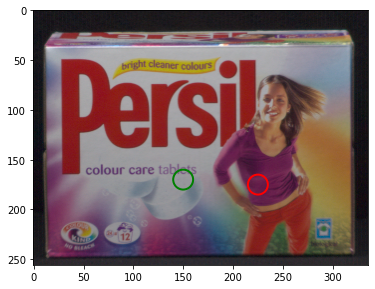

In [11]:
loc_1 = (225, 175)
loc_2 = (150, 170)

plt.figure(figsize=(6,6))

circle1 = plt.Circle(loc_1, 10, color='r', fill=False, lw=2, edgecolor='r')
circle2 = plt.Circle(loc_2, 10, color='g', fill=False, lw=2, edgecolor='g')
ax = plt.gca()
ax.add_patch(circle1)
ax.add_patch(circle2)
plt.imshow(RGBresult, cmap='Greys_r')


We plot a small patch of the image around those 2 locations:

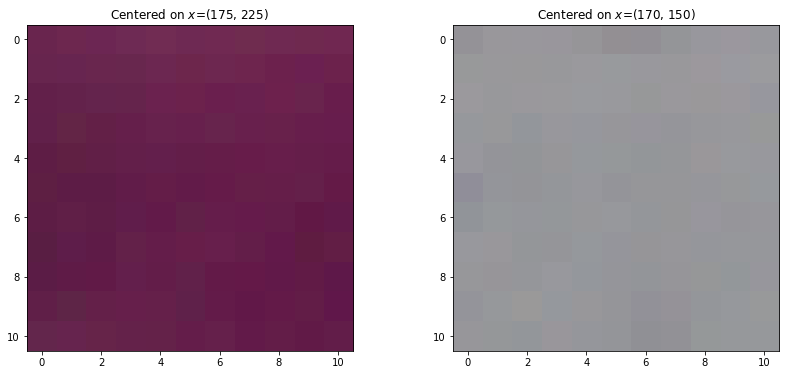

In [12]:
n = 5 # Size of the patch is 2n+1
plt.figure(figsize=(14,6))
for i, loc in enumerate([loc_1, loc_2]):
    plt.subplot(1, 2, i+1)
    x_min, x_max = loc[1]-n, loc[1]+n+1
    y_min, y_max = loc[0]-n, loc[0]+n+1
    plt.imshow(RGBresult[x_min:x_max, y_min:y_max, :], vmin=0., vmax=1.)
    plt.title(f'Centered on $x$=({loc[1]}, {loc[0]})')   

The first color difference formula, $\Delta E^*_{ab}$, has been proposed in 1976. You can see the details and the historical progress in the following: https://en.wikipedia.org/wiki/Color_difference#CIE76

This $\Delta E^*_{ab}$ color difference is defined as the Euclidian distance of two colors in the CIE L\*a\*b\* color space.


Fill in the code below to compute the $\Delta E^*_{ab}$ color difference between the two considered pixels.

In [13]:
# L_star_1, a_star_1, b_star_1 = ... Fill the code here
# L_star_2, a_star_2, b_star_2 = ... Fill the code here
L_star_1, a_star_1, b_star_1 = LABresult[loc_1[0], loc_1[1], :] #...
L_star_2, a_star_2, b_star_2 = LABresult[loc_2[0], loc_2[1], :] #...

deltaE = math.sqrt((L_star_1 - L_star_2)**2 + (a_star_1 - a_star_2)**2 + (b_star_1 - b_star_2)**2)
print(deltaE)

40.733167551391816


The color difference should be approximately 41. Try to run again the last few cells with different pixel locations. Observe that pixels with similar colors have a lower color difference.

This color difference formula $\Delta E^*_{ab}$ has been refined in 1994 and 2000. We will now use the package `colour-science` to compute those two other color difference metrics, $\Delta E^*_{94}$ and $\Delta E^*_{00}$.

In [14]:
Lab_1 = np.array([L_star_1, a_star_1, b_star_1])
Lab_2 = np.array([L_star_2, a_star_2, b_star_2])

print("delta_E_CIE1976 = ", delta_E_CIE1976(Lab_1, Lab_2))
print("delta_E_CIE1994 = ", delta_E_CIE1994(Lab_1, Lab_2))
print("delta_E_CIE2000 = ", delta_E_CIE2000(Lab_1, Lab_2))

delta_E_CIE1976 =  40.7331675514
delta_E_CIE1994 =  35.2183101933
delta_E_CIE2000 =  36.1606134097


Again, run the previous cells with different pixel locations and observe that pixels with similar colors have a lower color difference.

Guess which colors would have the highest distance and then evaluate your hypothesis!

# Part 2
--------------------------
## Color gamuts and CIE xy chromaticity diagram

In [15]:
%cd "../Homework 2 Color Science"

/content/CS413-ComputationalPhotography/Homework 2 Color Science


In [16]:
from color_space_transform import color_space_transform
from data import load_fw
from utils import xy_inside_horseshoe

### CIE xy chromaticity diagram

In this section, we are trying to understand and reproduce the CIE xy chromaticity diagram, widely used to represent color gamuts:

<a title="BenRG, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:CIE1931xy_blank.svg"><img width="256" alt="CIE1931xy blank" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/CIE1931xy_blank.svg/256px-CIE1931xy_blank.svg.png"></a>

The CIE XYZ color space is a standard color space used in many industries to represent colors. It was designed to mimic the way the human eye perceives color. The $Y$ parameter in this color space is a measure of the luminance of a color. The chromaticity is specified by the two derived parameters $x$ and $y$:

$$x = X / (X+Y+Z)$$
$$y = Y / (X+Y+Z)$$

The CIE xyY color space is a derived color space specified by $x$, $y$, and $Y$. It is widely used to specify colors in practice. Fill in the code below to calculate the chromaticity coordinates x and y from points in the CIE XYZ color space.

In [17]:
def get_chromaticity_xy(XYZ):
    """ get_chromaticity_xy(XYZ) calculates the chromaticity coordinates x and y
    from points in the CIE XYZ color space.
    
    XYZ is a numpy array with 3 rows and n>=1 columns
    Each column corresponds to one color in the CIE XYZ color space,
    where the primaries X, Y, and Z of the colors are given in the
    first, second, and third row respectively.
    This function returns another numpy array xy with 2 rows and n columns.
    """
    assert len(XYZ.shape) == 2 and XYZ.shape[0] == 3
    # xyz = ... Write your code here to calculate xyz from XYZ
    # xy = .... Write your code here to calculate xy from xyz
    xyz = XYZ / np.sum(XYZ, axis = 0) #...
    xy = xyz[:2, :] #...
    return xy

The following cell loads 2 arrays, `monochromatic_cie_XYZ` and `wavelengths`.

`wavelengths` contains some wavelength values in nanometers, and `monochromatic_cie_XYZ` contains points in the CIE XYZ color space. Those points represents the color of monochromatic responses (i.e., single wavelength) with those specified wavelengths.

In [18]:
monochromatic_cie_XYZ, wavelengths = load_fw("xyz-cmfs")
print(wavelengths.shape, monochromatic_cie_XYZ.shape)
print(wavelengths[:5])
print(monochromatic_cie_XYZ[:, :5])

(471,) (3, 471)
[ 360.  361.  362.  363.  364.]
[[  1.29900000e-04   1.45847000e-04   1.63802100e-04   1.84003700e-04
    2.06690200e-04]
 [  3.91700000e-06   4.39358100e-06   4.92960400e-06   5.53213600e-06
    6.20824500e-06]
 [  6.06100000e-04   6.80879200e-04   7.65145600e-04   8.60012400e-04
    9.66592800e-04]]


Use the function `get_chromaticity_xy` to obtain the monochromatic responses in the $xy$ space.

In [19]:
monochromatic_cie_xy = get_chromaticity_xy(monochromatic_cie_XYZ) #...
assert monochromatic_cie_xy.shape == (2, 471)

The cell below should plot the monochromatic responses in the $xy$ space:

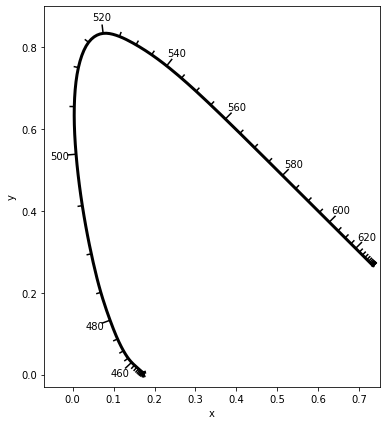

In [20]:
def plot_horseshoe_curve(ax, xy, wavelengths):
    """Plot the horseshoe curve with wavelength ticks alongside."""
    ax.plot(xy[0,:], xy[1,:], color='k', linewidth=3)

    small_ticks = np.arange(400, 700, 5)
    large_ticks = np.arange(460, 640, 20)
    small_tick_size = 0.01
    large_tick_size = 0.02
    text_distance = 0.04
    tick_indices = [i for i in range(len(wavelengths)) \
                    if (wavelengths[i] in small_ticks) or (wavelengths[i] in large_ticks)]
    for i in tick_indices:
        # Compute tick direction.
        x,y = xy[0,i], xy[1,i]
        xp,yp = xy[0,i-1], xy[1,i-1]
        xn,yn = xy[0,i+1], xy[1,i+1]
        angle = np.arctan2(yn-yp, xn-xp) + np.pi / 2
        # Plot tick according to tick size.
        ts = (wavelengths[i] in large_ticks) and large_tick_size or small_tick_size
        ax.plot([x, x + ts*np.cos(angle)], [y, y + ts*np.sin(angle)], 'k')
        # Draw texts.
        if wavelengths[i] in large_ticks:
            td = text_distance
            ax.text(x+td*np.cos(angle), y+td*np.sin(angle), str(int(wavelengths[i])),
                    ha="center", va="center")


ax = plt.figure(figsize=(7,7)).gca()
plot_horseshoe_curve(ax, monochromatic_cie_xy, wavelengths)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect("equal")
ax.set_xlim(-0.07, 0.75)
ax.set_ylim(-0.03, 0.9)
plt.show()

We create an image representing all possible $(x, y)$ values. This image is first created in the xyY color space with unit luminance ($Y = 1$ for all pixels).

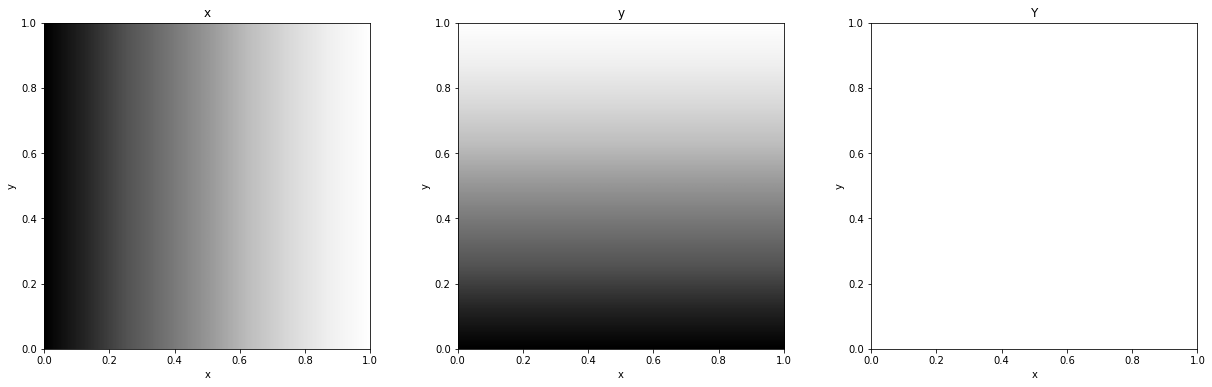

In [21]:
size = 1001
horseshoe_xyY = np.zeros((size, size, 3))
(xx,yy) = np.meshgrid(np.linspace(0, 1, size),
                      np.linspace(1, 0, size))
horseshoe_xyY[:,:,0] = xx
horseshoe_xyY[:,:,1] = yy
horseshoe_xyY[:,:,2] = 1

plt.figure(figsize=(21,6))
for i, channel in enumerate(('x', 'y', 'Y')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_xyY[:,:,i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel)    

The colors that are outside of the horseshoe curve cannot be reached by combination of different wavelengths of light, hence, we remove them.

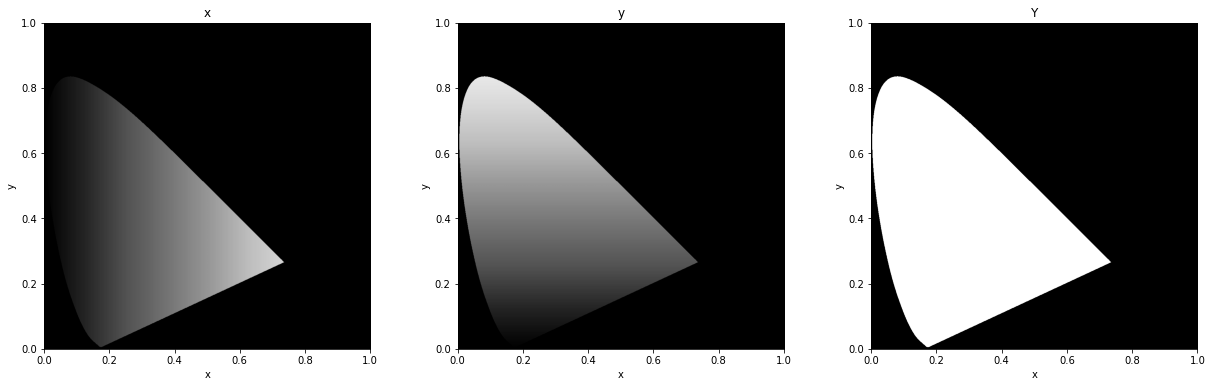

In [22]:
inside = xy_inside_horseshoe(xx, yy, monochromatic_cie_xy.T)
for c in range(3):
    horseshoe_c = horseshoe_xyY[:,:,c]
    horseshoe_c[~inside] = 0.0
    horseshoe_xyY[:,:,c] = horseshoe_c

plt.figure(figsize=(21,6))
for i, channel in enumerate(('x', 'y', 'Y')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_xyY[:,:,i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel)    

We then transform the image from xyY to sRGB color space to display it.

In [23]:
# Convert the image into linear sRGB color space.
horseshoe_XYZ = color_space_transform(horseshoe_xyY, "CIE-xyY", "CIE-XYZ")
horseshoe_sRGB_linear = color_space_transform(
    horseshoe_XYZ, "CIE-XYZ", "sRGB-linear")

# Convert to nonlinear sRGB data.
horseshoe_sRGB = color_space_transform(
    horseshoe_sRGB_linear, "sRGB-linear", "sRGB")
horseshoe_sRGB[horseshoe_sRGB<0] = 0.0
horseshoe_sRGB[horseshoe_sRGB>1] = 1.0

horseshoe_XYZ


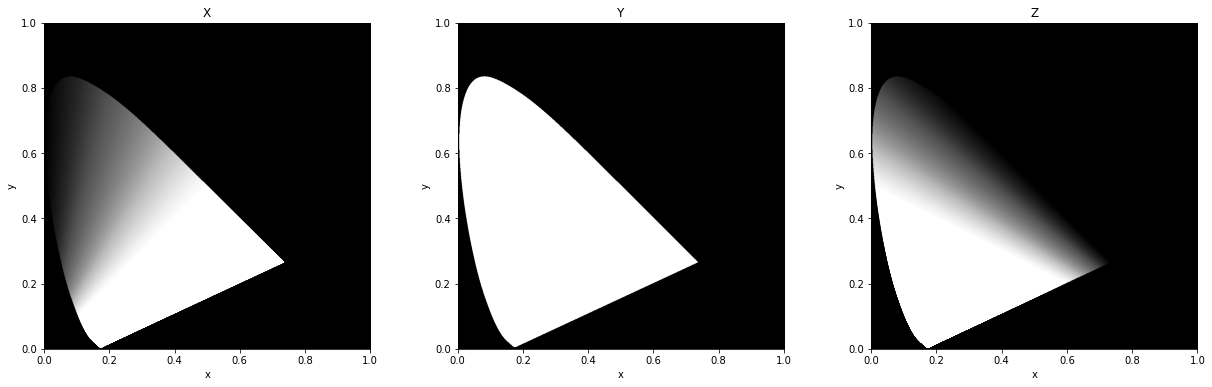

horseshoe_sRGB_linear


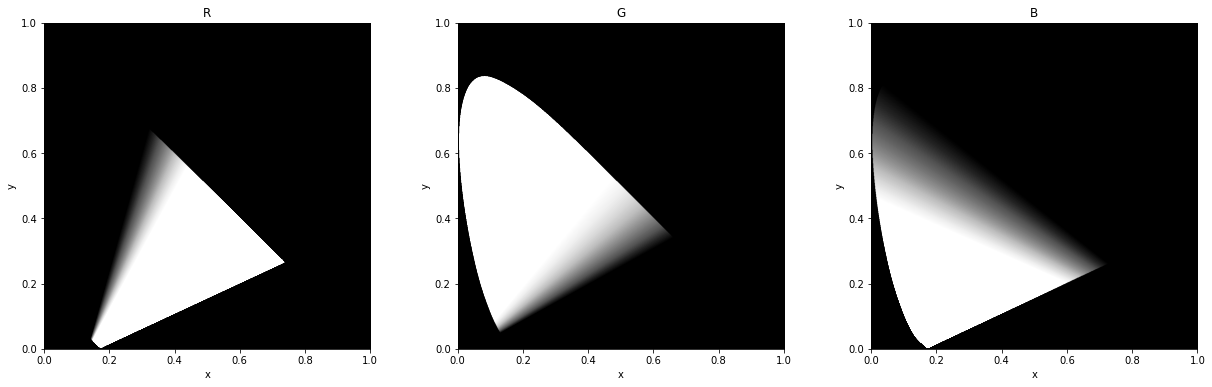

horseshoe_sRGB


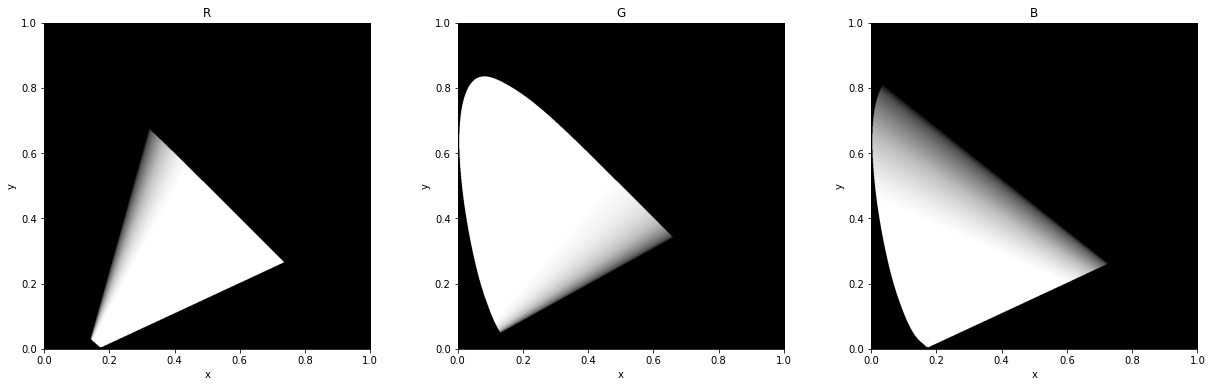

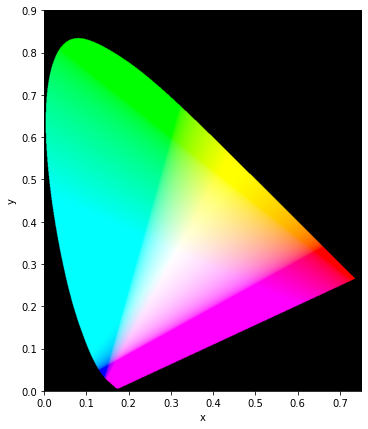

In [24]:
print("horseshoe_XYZ")
plt.figure(figsize=(21,6))
for i, channel in enumerate(('X', 'Y', 'Z')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_XYZ[:, :, i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel)
plt.show()

print("horseshoe_sRGB_linear")
plt.figure(figsize=(21,6))
for i, channel in enumerate(('R', 'G', 'B')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_sRGB_linear[:, :, i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel)
plt.show()

print("horseshoe_sRGB")
plt.figure(figsize=(21,6))
for i, channel in enumerate(('R', 'G', 'B')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_sRGB[:, :, i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel) 

ax = plt.figure(figsize=(7,7)).gca()
ax.imshow(horseshoe_sRGB[:, :, :], extent=[0, 1, 0, 1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0, 0.75)
ax.set_ylim(0, 0.9)
plt.show()

Question: Do you see any issue in this color gamut? What could be the reason for it? (HINT: next cell)

Your answer: ?

Answer: Unit luminance (Y=1)

In [25]:
def normalize_image_by_max_color(image):
    """Normalize each pixel of an image by the maximum color channel. The input
    image will be modified in place."""
    image_max = np.max(image[:,:,:3], axis = 2)
    for c in range(3):
        image_c = image[:,:,c]
        image_c[image_max>0] = image_c[image_max>0] / image_max[image_max>0]
        image[:,:,c] = image_c
    return image

# Convert the image into linear sRGB color space.
horseshoe_XYZ = color_space_transform(horseshoe_xyY, "CIE-xyY", "CIE-XYZ")
horseshoe_sRGB_linear = color_space_transform(
    horseshoe_XYZ, "CIE-XYZ", "sRGB-linear")

# Normalizing the image by the maximum color component 
horseshoe_sRGB_linear = normalize_image_by_max_color(horseshoe_sRGB_linear)

# Convert to nonlinear sRGB data.
horseshoe_sRGB = color_space_transform(
    horseshoe_sRGB_linear, "sRGB-linear", "sRGB")
horseshoe_sRGB[horseshoe_sRGB<0] = 0.0
horseshoe_sRGB[horseshoe_sRGB>1] = 1.0

horseshoe_XYZ


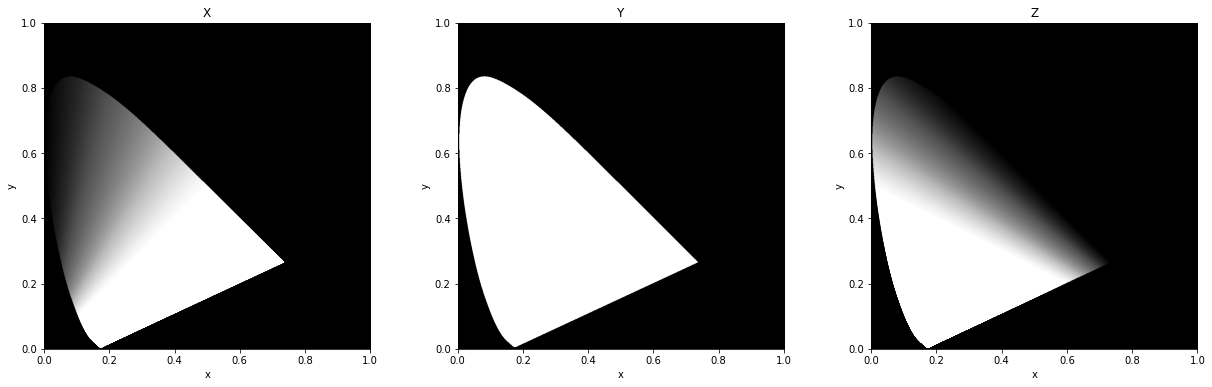

horseshoe_sRGB_linear


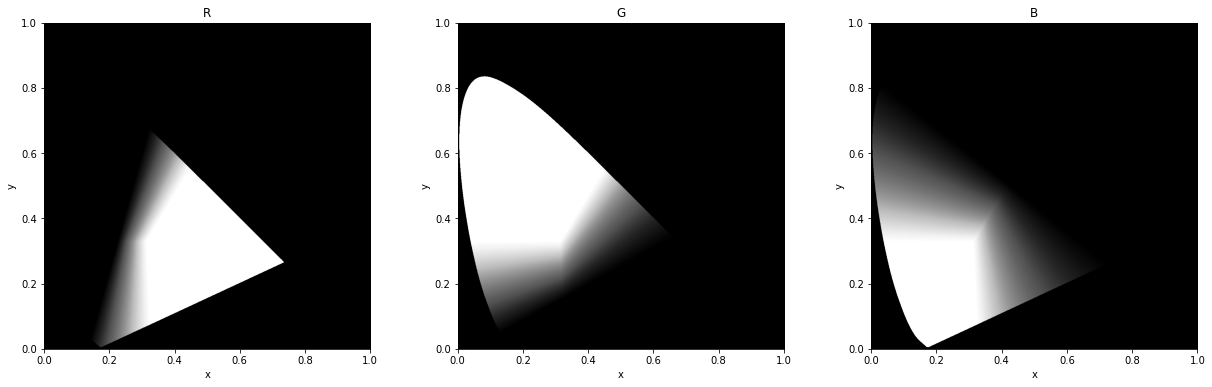

horseshoe_sRGB


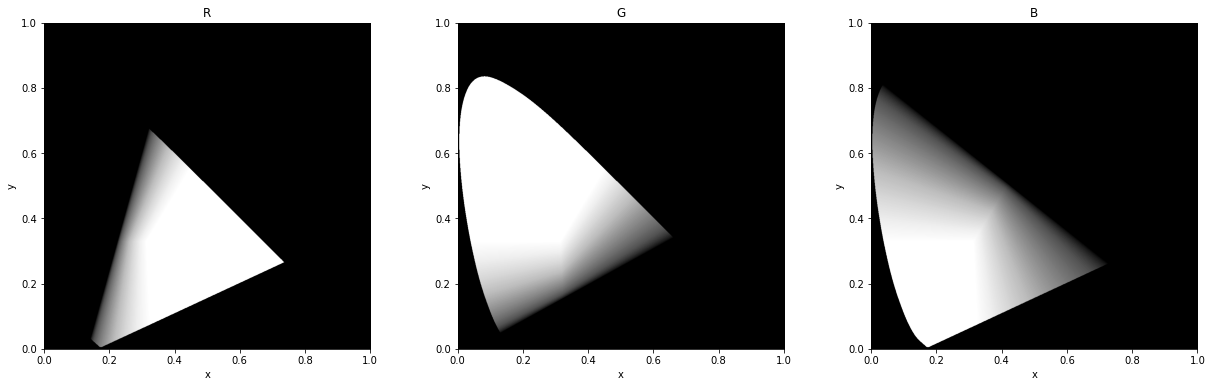

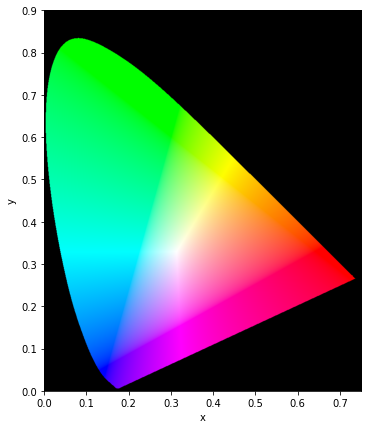

In [26]:
print("horseshoe_XYZ")
plt.figure(figsize=(21,6))
for i, channel in enumerate(('X', 'Y', 'Z')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_XYZ[:, :, i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel)
plt.show()

print("horseshoe_sRGB_linear")
plt.figure(figsize=(21,6))
for i, channel in enumerate(('R', 'G', 'B')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_sRGB_linear[:, :, i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel)
plt.show()

print("horseshoe_sRGB")
plt.figure(figsize=(21,6))
for i, channel in enumerate(('R', 'G', 'B')):
    plt.subplot(1,3,i+1)
    plt.imshow(horseshoe_sRGB[:, :, i], vmin=0., vmax=1., cmap='Greys_r', extent=[0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(channel) 

ax = plt.figure(figsize=(7,7)).gca()
ax.imshow(horseshoe_sRGB[:, :, :], extent=[0, 1, 0, 1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0, 0.75)
ax.set_ylim(0, 0.9)
plt.show()

We now replace the black pixels by white ones:

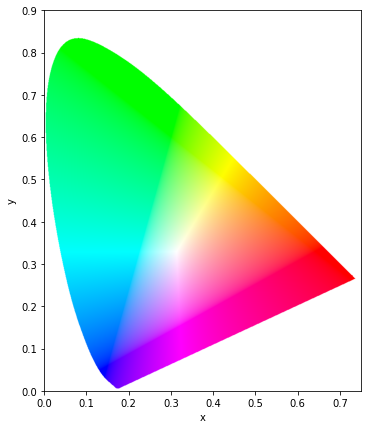

In [27]:
invalid_pixels = np.max(horseshoe_sRGB, axis=-1) == 0.
horseshoe_sRGB[invalid_pixels, :] = 1.

ax = plt.figure(figsize=(7,7)).gca()
ax.imshow(horseshoe_sRGB[:, :, :], extent=[0,1,0,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect("equal")
ax.set_xlim(0, 0.75)
ax.set_ylim(0, 0.9)
plt.show()

We emphasize the points where the plane cuts the monochromatic spectra-response, by overlapping the 2 previously computed parts:

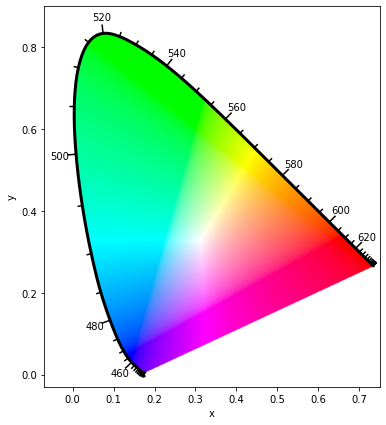

In [28]:
ax = plt.figure(figsize=(7,7)).gca()
ax.imshow(horseshoe_sRGB[:, :, :], extent=[0,1,0,1])
plot_horseshoe_curve(ax, monochromatic_cie_xy, wavelengths)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect("equal")
ax.set_xlim(-0.07, 0.75)
ax.set_ylim(-0.03, 0.9)
plt.show()

### sRGB and Adobe RGB color spaces

In the following we'll superimpose the gamuts of two color spaces on the CIE xy.

In [29]:
def plot_triangle(ax, tri, *args, **kw):
    """Plot a triangle in the axis."""
    assert tri.shape == (2,3)
    ax.plot((tri[0,0], tri[0,1], tri[0,2], tri[0,0]),
            (tri[1,0], tri[1,1], tri[1,2], tri[1,0]), *args, **kw)

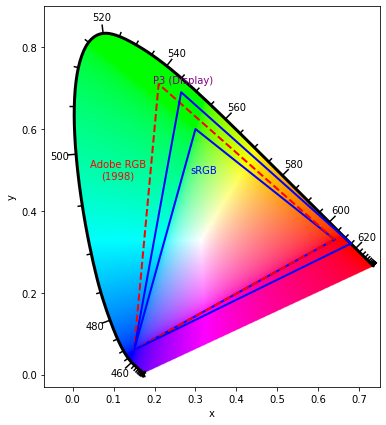

In [30]:
from data import srgb_red_xyz, srgb_green_xyz, srgb_blue_xyz
from data import adobe_red_xy, adobe_green_xy, adobe_blue_xy
from data import p3_red_xy, p3_green_xy, p3_blue_xy

ax = plt.figure(figsize=(7,7)).gca()
ax.imshow(horseshoe_sRGB[:, :, :], extent=[0,1,0,1])
plot_horseshoe_curve(ax, monochromatic_cie_xy, wavelengths)

# Plot the sRGB triangle.
srgb_triangle_xyz = np.array([srgb_red_xyz, srgb_green_xyz, srgb_blue_xyz]).T
plot_triangle(ax, srgb_triangle_xyz[:2,:], color="b", linewidth=2)
ax.text(0.32, 0.5, "sRGB", ha="center", va="center", color="b")

# Plot Adobe RGB (1998) triangle.
adobe_triangle_xy = np.array([adobe_red_xy, adobe_green_xy, adobe_blue_xy]).T
plot_triangle(ax, adobe_triangle_xy, "--r", linewidth=2)
ax.text(0.11, 0.5, "Adobe RGB\n(1998)", ha="center", va="center", color="r")

# Plot the P3 triangle.
p3_triangle_xy = np.array([p3_red_xy, p3_green_xy, p3_blue_xy]).T
plot_triangle(ax, p3_triangle_xy[:2,:], color="b", linewidth=2)
ax.text(0.27, 0.72, "P3 (Display)", ha="center", va="center", color="purple")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect("equal")
ax.set_xlim(-0.07, 0.75)
ax.set_ylim(-0.03, 0.9)
plt.show()

### Chromaticities of images in different color spaces

Take a look at this website to see images at different color spaces. Is your monitor able to show the difference between the images?

https://webkit.org/blog-files/color-gamut/

In [31]:
# The dictionnary indicates the link to download the image and the original color space of the image
img_name2url = {

    "Shoes-sRGB": "https://webkit.org/blog-files/color-gamut/Shoes-sRGB.jpg",
    "Shoes-AdobeRGB": "https://webkit.org/blog-files/color-gamut/Shoes-AdobeRGB.jpg",
    
    "Iceland-sRGB": "https://webkit.org/blog-files/color-gamut/Iceland-sRGB.jpg",
    "Iceland-P3": "https://webkit.org/blog-files/color-gamut/Iceland-P3.jpg",

    "Rose-sRGB": "https://webkit.org/blog-files/color-gamut/Rose-sRGB.jpg",
    "Rose-AdobeRGB": "https://webkit.org/blog-files/color-gamut/Rose-AdobeRGB.jpg",
}

# Matrices to convert various RGB color spaces to XYZ
# Mostly from http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html
matrices_RGB_to_XYZ = {
    "AdobeRGB":  np.array([
        [0.5767309, 0.1855540, 0.1881852],
        [0.2973769, 0.6273491, 0.0752741],
        [0.0270343, 0.0706872, 0.9911085],
    ]),
    "sRGB": np.array([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041],
    ]), 
    "P3": np.array([
        [0.45506, 0.30024, 0.1804375],
        [0.21269, 0.70939, 0.0721750],
        [0.00052, 0.0552, 0.9503041],
    ]),
}


Let's download the image in the sRGB color space.

In [32]:
target_img_key =  "Shoes-sRGB"
image_name, colorspace = target_img_key.split("-")

img_url = img_name2url[target_img_key]
matrix_RGB_to_XYZ = matrices_RGB_to_XYZ[colorspace]

im_RGB = imageio.imread(img_url)

# Now we need to undo the gamma correction:
if colorspace in ["sRGB", "P3"]:
  im_RGB = color_space_transform(im_RGB, "sRGB", "sRGB-linear")
elif colorspace == "AdobeRGB":
  im_RGB = np.power(im_RGB,  2.2)
else:
  pass


print(im_RGB.shape)

<ipython-input-32-342957114f6f>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_RGB = imageio.imread(img_url)


(400, 600, 3)


Now let's convert the downloaded image from its original color space to xyz  

In [33]:
im_XYZ = np.einsum("ij, xyj -> xyi", matrix_RGB_to_XYZ, im_RGB)
print(im_XYZ.shape)

# We add a small value in the denominator to avoid devision by zero.
im_xyz = im_XYZ / (np.sum(im_XYZ, axis = 2, keepdims = True) + 1e-8) 
print(im_xyz.shape)

im_xy = im_xyz[:, :, :2]
print(im_xy.shape)

pixel_colors = im_xy.reshape(-1, 2)
print(pixel_colors.shape)

(400, 600, 3)
(400, 600, 3)
(400, 600, 2)
(240000, 2)


Now we can scatter the xy component of all the pixels in the image inside the color gamut. 

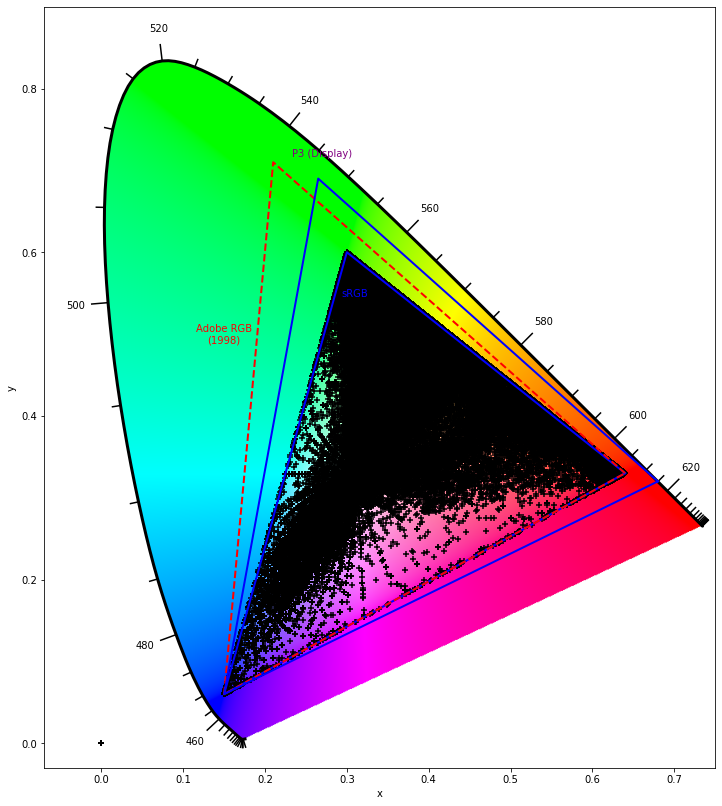

In [34]:
ax = plt.figure(figsize=(14,14)).gca()

ax.imshow(horseshoe_sRGB[:, :, :], extent=[0,1,0,1])
plot_horseshoe_curve(ax, monochromatic_cie_xy, wavelengths)

ax.scatter(pixel_colors[:, 0], pixel_colors[:, 1], marker="+", color='black' )

# Plot the sRGB triangle.
srgb_triangle_xyz = np.array([srgb_red_xyz, srgb_green_xyz, srgb_blue_xyz]).T
plot_triangle(ax, srgb_triangle_xyz[:2,:], color="b", linewidth=2)
ax.text(0.31, 0.55, "sRGB", ha="center", va="center", color="b")

# Plot Adobe RGB (1998) triangle.
adobe_triangle_xy = np.array([adobe_red_xy, adobe_green_xy, adobe_blue_xy]).T
plot_triangle(ax, adobe_triangle_xy, "--r", linewidth=2)
ax.text(0.15, 0.5, "Adobe RGB\n(1998)", ha="center", va="center", color="r")


# Plot the P3 triangle.
p3_triangle_xy = np.array([p3_red_xy, p3_green_xy, p3_blue_xy]).T
plot_triangle(ax, p3_triangle_xy[:2,:], color="b", linewidth=2)
ax.text(0.27, 0.72, "P3 (Display)", ha="center", va="center", color="purple")


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect("equal")
ax.set_xlim(-0.07, 0.75)
ax.set_ylim(-0.03, 0.9)
plt.show()